## DJENT吗？（DOES IT DJENT?）

### 人工智能的：在吉他上深度学习

DJENT 是一个动词。意思是很重的吉他音乐。弹很低的吉他线，听起来像“DJENT”：一个象声词。比如其他的象声词：嘎嘎，哈哈，呼噜声，呵呵

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *

In [3]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [4]:
PATH = "data/DOES_IT_DJENT/"
sz=224

In [5]:
torch.cuda.is_available()

True

In [6]:
torch.backends.cudnn.enabled

True

### googleimagesdownload data organization train val test split

In [52]:
# First move everything into the folder ./downloads/{class}/*
# Put everything to desired quantities to ./train/{class}/*, ./valid/{class}/*, and ./test/{class}/*
DL_PATH = '/home/paperspace/fastai/courses/dl1/data/DOES_IT_DJENT/downloads'
!ls {DL_PATH}
!shuf -n 60 -e ${DL_PATH}/DOES_DJENT/* | xargs -i mv {} ${DL_PATH}/../test/DOES_DJENT/
!shuf -n 60 -e ${DL_PATH}/DOES_DJENT/* | xargs -i mv {} ${DL_PATH}/../valid/DOES_DJENT/
!mv ${DL_PATH}/DOES_DJENT/* ${DL_PATH}/../train/DOES_DJENT/

!shuf -n 20 -e ${DL_PATH}/DOES_NOT_DJENT/* | xargs -i mv {} ${DL_PATH}/../test/DOES_NOT_DJENT/
!shuf -n 20 -e ${DL_PATH}/DOES_NOT_DJENT/* | xargs -i mv {} ${DL_PATH}/../valid/DOES_NOT_DJENT/
!mv ${DL_PATH}/DOES_NOT_DJENT/* ${DL_PATH}/../train/DOES_NOT_DJENT/


DOES_DJENT  DOES_NOT_DJENT
mv: cannot stat '/DOES_DJENT/*': No such file or directory
mv: cannot stat '/DOES_DJENT/*': No such file or directory
mv: cannot stat '$/home/paperspace/fastai/courses/dl1/data/DOES_IT_DJENT/downloads/DOES_DJENT/*': No such file or directory
mv: cannot stat '/DOES_NOT_DJENT/*': No such file or directory
mv: cannot stat '/DOES_NOT_DJENT/*': No such file or directory
mv: cannot stat '$/home/paperspace/fastai/courses/dl1/data/DOES_IT_DJENT/downloads/DOES_NOT_DJENT/*': No such file or directory


## First look at weak pictures that do not djent

Note:
DOES_NOT_DJENT was made with 6 string guitars
DOES_DJENT was made with 7, 8, and 9 string guitars

In [7]:
os.listdir(PATH)

['test', 'valid', 'models', 'downloads', 'train', 'tmp']

In [8]:
!tree {PATH}. -d

data/DOES_IT_DJENT/.
├── downloads
│   ├── DOES_DJENT
│   └── DOES_NOT_DJENT
├── models
├── test
│   ├── DOES_DJENT
│   └── DOES_NOT_DJENT
├── tmp
│   ├── x_act_resnet34_0_224.bc
│   │   ├── data
│   │   └── meta
│   ├── x_act_test_resnet34_0_224.bc
│   │   ├── data
│   │   └── meta
│   └── x_act_val_resnet34_0_224.bc
│       ├── data
│       └── meta
├── train
│   ├── DOES_DJENT
│   └── DOES_NOT_DJENT
└── valid
    ├── DOES_DJENT
    └── DOES_NOT_DJENT

23 directories


In [9]:
os.listdir(f'{PATH}valid')

['DOES_NOT_DJENT', 'DOES_DJENT']

In [10]:
files = os.listdir(f'{PATH}valid/DOES_NOT_DJENT')[:5]
files

['50. 501620000001000-00-500x500.jpg',
 '69. 423063000049000-00-500x500.jpg',
 '70. 4-string-bass-6-string-lead-headless-busuyi-guitar.jpg',
 '6. yamaha-a3m-vs-electro-acoustic-guitar-6-string-dreadnought-body-guitar-by-sherwood-phoenix.jpg',
 '18. 0000848_ibanez-btb1806-ntl-bass-guitar-6-string.jpg']

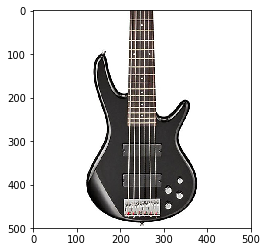

In [11]:
img = plt.imread(f'{PATH}valid/DOES_NOT_DJENT/{files[0]}')
plt.imshow(img);

Here is how the raw data looks like

In [12]:
img.shape

(500, 500, 3)

In [13]:
img[:4,:4]

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]], dtype=uint8)

## Our first model: quick start

In [14]:
arch=resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                
    0      1.030622   0.554266   0.730769  
    1      0.809376   0.503059   0.717949        



[array([ 0.50306]), 0.7179487194770422]

As well as looking at the overall metrics, it's also a good idea to look at examples of each of:
1. A few correct labels at random
2. A few incorrect labels at random
3. The most correct labels of each class (ie those with highest probability that are correct)
4. The most incorrect labels of each class (ie those with highest probability that are incorrect)
5. The most uncertain labels (ie those with probability closest to 0.5).

In [17]:
# This is the label for a val data
data.val_y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [18]:
# from here we know that 'cats' is label 0 and 'dogs' is label 1.
data.classes

['DOES_DJENT', 'DOES_NOT_DJENT']

In [21]:
# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()
log_preds.shape

(78, 2)

In [22]:
log_preds[:10] # these are predictions for [dog, cat]. This is the log though, so exponentiate them

array([[-0.34499, -1.23179],
       [-0.32089, -1.29281],
       [-0.20798, -1.67252],
       [-0.4061 , -1.09734],
       [-0.5009 , -0.93136],
       [-0.08759, -2.47856],
       [-0.15942, -1.91488],
       [-0.277  , -1.41905],
       [-0.09008, -2.45172],
       [-0.26926, -1.44369]], dtype=float32)

In [23]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])        # pr(dog)

In [24]:
probs

array([ 0.29177,  0.2745 ,  0.18777,  0.33376,  0.39402,  0.08386,  0.14736,  0.24194,  0.08615,  0.23606,
        0.18807,  0.23995,  0.28002,  0.12982,  0.50235,  0.14337,  0.2939 ,  0.4289 ,  0.16699,  0.58949,
        0.1426 ,  0.57178,  0.12932,  0.12661,  0.35996,  0.14163,  0.05882,  0.07392,  0.21921,  0.67785,
        0.26376,  0.40417,  0.32643,  0.32086,  0.06022,  0.33308,  0.2439 ,  0.29169,  0.53632,  0.22407,
        0.2737 ,  0.10612,  0.63973,  0.21652,  0.28366,  0.37973,  0.81128,  0.19319,  0.46926,  0.09614,
        0.48799,  0.16873,  0.06272,  0.67953,  0.52313,  0.10704,  0.67805,  0.23558,  0.39402,  0.28778,
        0.41596,  0.38364,  0.35418,  0.77579,  0.52387,  0.16372,  0.24763,  0.15981,  0.94707,  0.37038,
        0.92103,  0.31654,  0.42908,  0.41105,  0.34764,  0.64571,  0.46731,  0.72809], dtype=float32)

In [25]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [26]:
def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

In [27]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [28]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

Correctly classified


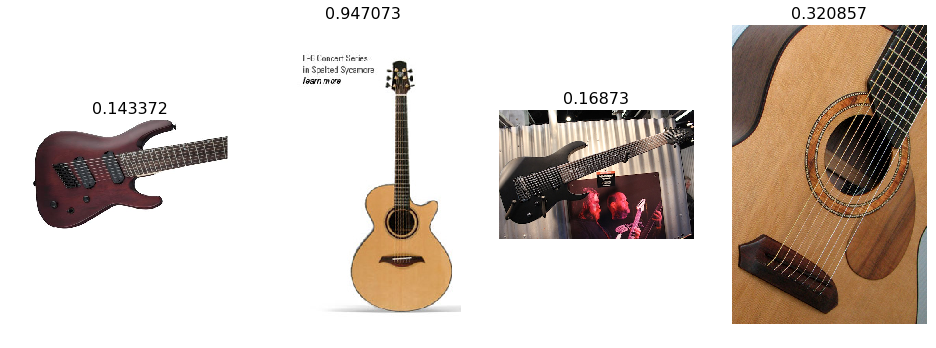

In [29]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

Incorrectly classified


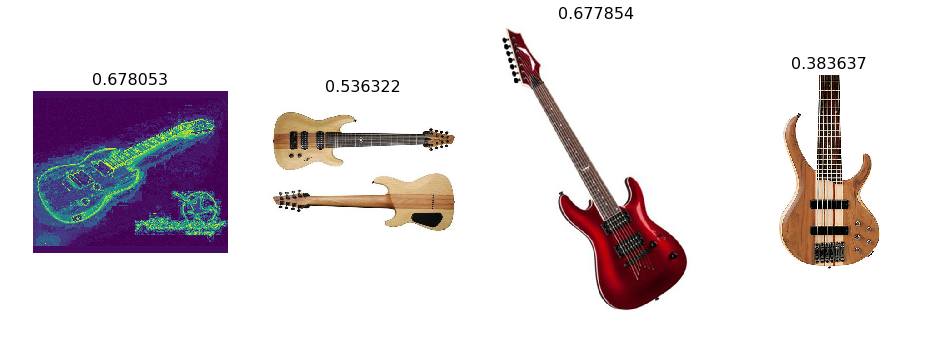

In [35]:
# 2. A few incorrect labels at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

In [36]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Things that COMPLETELY DJENT


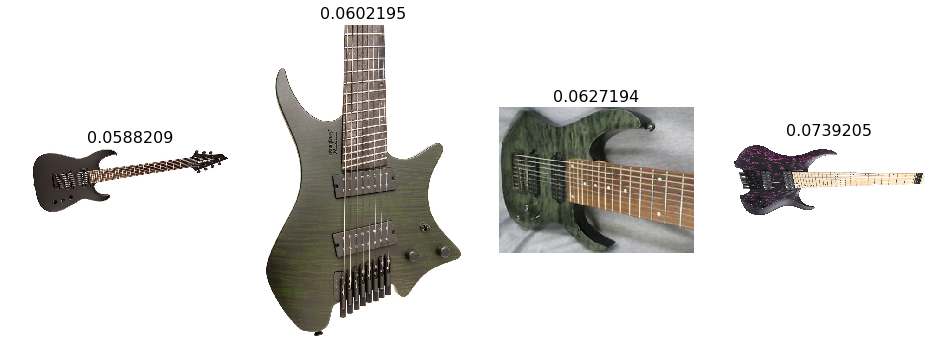

In [37]:
plot_val_with_title(most_by_correct(0, True), "Things that COMPLETELY DJENT")

Doesn't djent


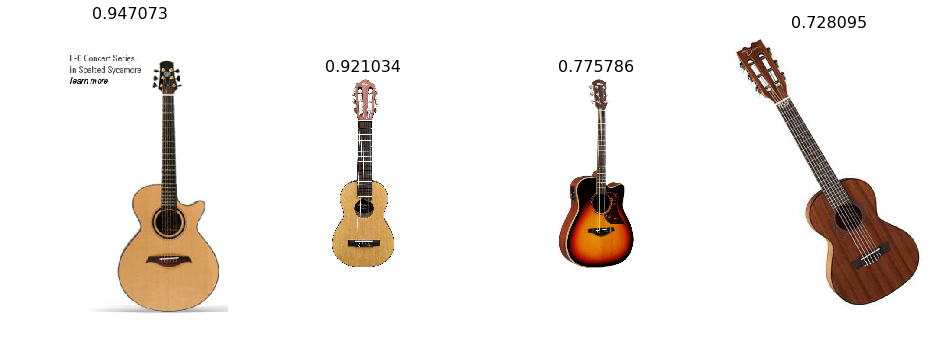

In [38]:
plot_val_with_title(most_by_correct(1, True), "Doesn't djent")

Most incorrect things that actually DJENT


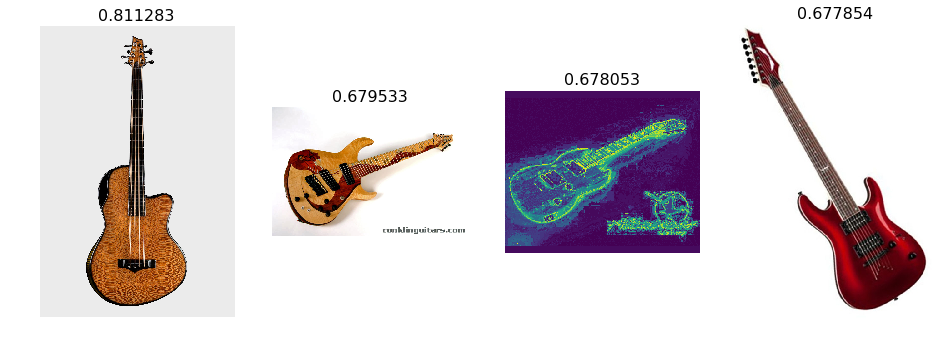

In [39]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect things that actually DJENT")

Most incorrect things that don't actually DJENT


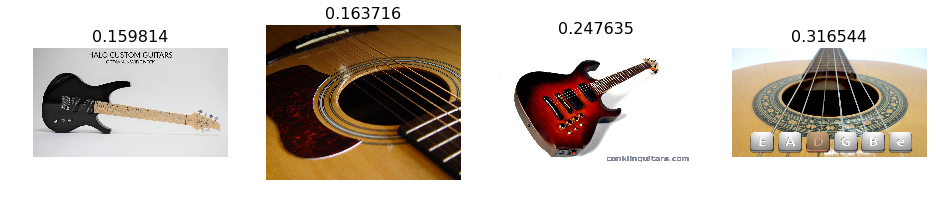

In [42]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect things that don't actually DJENT")

Most uncertain predictions


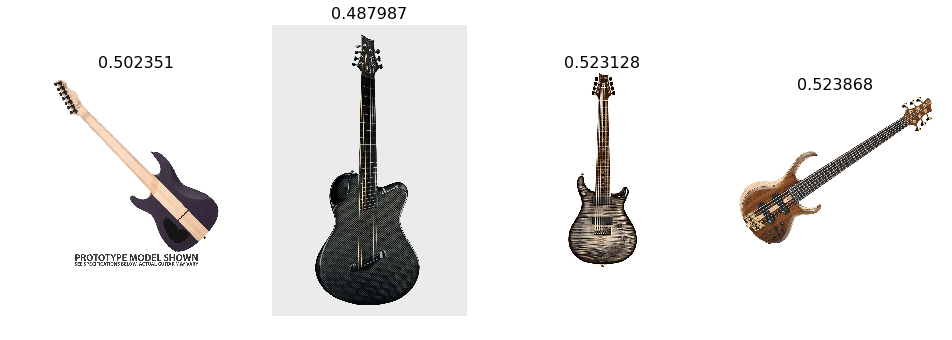

In [45]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

## Improving our model

### Data augmentation

If you try training for more epochs, you'll notice that we start to *overfit*, which means that our model is learning to recognize the specific images in the training set, rather than generalizing such that we also get good results on the validation set. One way to fix this is to effectively create more data, through *data augmentation*. This refers to randomly changing the images in ways that shouldn't impact their interpretation, such as horizontal flipping, zooming, and rotating.

We can do this by passing `aug_tfms` (*augmentation transforms*) to `tfms_from_model`, with a list of functions to apply that randomly change the image however we wish. For photos that are largely taken from the side (e.g. most photos of dogs and cats, as opposed to photos taken from the top down, such as satellite imagery) we can use the pre-defined list of functions `transforms_side_on`. We can also specify random zooming of images up to specified scale by adding the `max_zoom` parameter.

In [49]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [50]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [51]:
ims = np.stack([get_augs() for i in range(6)])

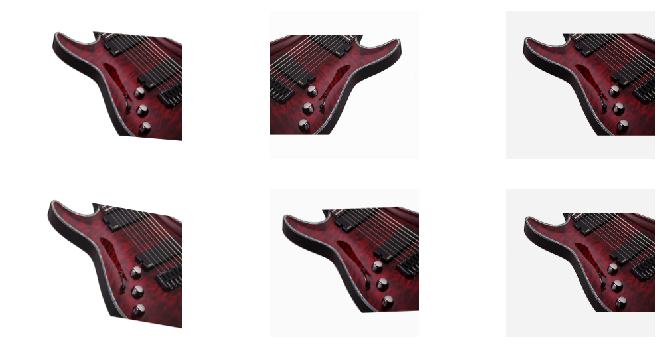

In [52]:
plots(ims, rows=2)

Let's create a new `data` object that includes this augmentation in the transforms.

In [53]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [54]:
learn.fit(1e-2, 1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy        
    0      0.918002   0.758271   0.551282  



[array([ 0.75827]), 0.55128205128205132]

In [55]:
learn.precompute=False

By default when we create a learner, it sets all but the last layer to *frozen*. That means that it's still only updating the weights in the last layer when we call `fit`.

In [58]:
learn.fit(1e-2, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                
    0      0.40868    0.535264   0.705128  
    1      0.427298   0.537051   0.730769                
    2      0.43441    0.535667   0.730769                



[array([ 0.53567]), 0.73076923115131187]

In [60]:
learn.save('224_DJENT_lastlayer')

In [61]:
learn.load('224_DJENT_lastlayer')

### Fine-tuning and differential learning rate annealing

In [62]:
learn.unfreeze()

In [63]:
lr=np.array([1e-4,1e-3,1e-2])

In [64]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                
    0      0.474477   0.512139   0.730769  
    1      0.500389   0.506581   0.75641                 
    2      0.462307   0.485442   0.782051                
    3      0.454541   0.475443   0.782051                
    4      0.441525   0.469544   0.769231                
    5      0.413355   0.471412   0.769231                
    6      0.385881   0.471552   0.769231                



[array([ 0.47155]), 0.76923077075909341]

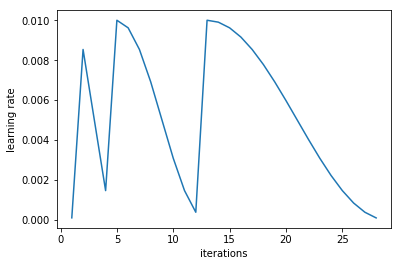

In [65]:
learn.sched.plot_lr()

In [66]:
learn.save('224_DJENT_all')

In [67]:
learn.load('224_DJENT_all')

## TTA

In [68]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

In [69]:
accuracy_np(probs, y)

0.80769230769230771

## Analyzing results

### Confusion matrix 

In [70]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

A common way to analyze the result of a classification model is to use a [confusion matrix](http://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/). Scikit-learn has a convenient function we can use for this purpose:

In [71]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

We can just print out the confusion matrix, or we can show a graphical view (which is mainly useful for dependents with a larger number of categories).

[[55  5]
 [10  8]]


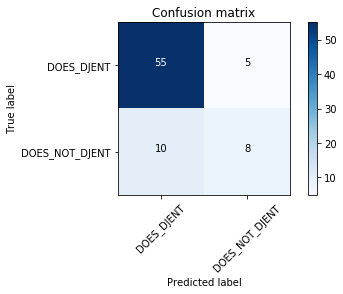

In [72]:
plot_confusion_matrix(cm, data.classes)

### Looking at pictures again

Most incorrect things that do actually DJENT


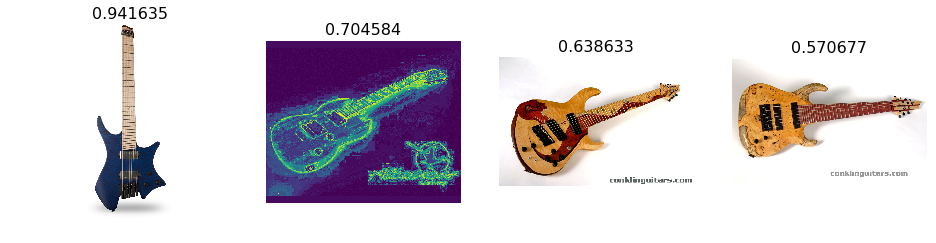

In [74]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect things that do actually DJENT")

Most incorrect things that don't actually DJENT


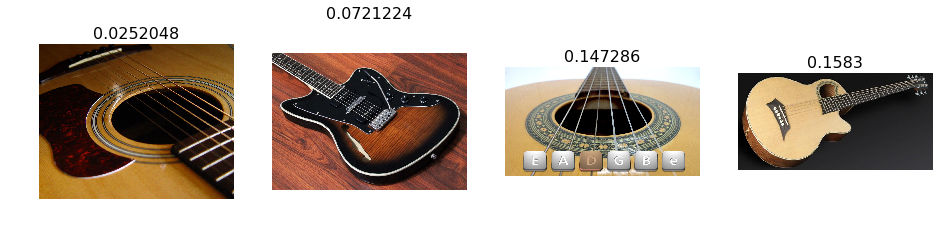

In [76]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect things that don't actually DJENT")

## Analyzing results: loss and accuracy

In [80]:
def binary_loss(y, p):
    return np.mean(-(y * np.log(p) + (1-y)*np.log(1-p)))

In [81]:
acts = np.array([1, 0, 0, 1])
preds = np.array([0.9, 0.1, 0.2, 0.8])
binary_loss(acts, preds)

0.164252033486018